<style>
/* --- 0. CONTAINER FIX --- */
body {
    overflow-x: hidden !important;
}
div#notebook-container, .container, .jp-Notebook {
    width: 100% !important;
    max-width: 100% !important;
    min-width: 0 !important;
    background-color: #ffffff !important;
}

/* --- 1. HIDE PROMPTS --- */
.prompt, 
.input_prompt, 
.output_prompt, 
.jp-InputPrompt,
.jp-OutputPrompt {
    display: none !important;
}

/* --- 2. FLAT INPUT/OUTPUT & BACKGROUND FIX --- */
/* This section targets the 'ash' background in printed outputs */
.jp-CodeCell,
.jp-InputArea-editor,
div.input_area,
.jp-OutputArea-output,
.output_subarea,
.output_wrapper,
.jp-RenderedText,
.jp-RenderedHTMLCommon pre,
.output_area pre, 
.output_text pre,
.jp-OutputArea-output pre,
.jp-RenderedText pre,
pre {
    background-color: transparent !important;
    border: none !important;
    border-radius: 0 !important;
    margin: 0 !important;
    color: #000000 !important;
    box-shadow: none !important;
}

/* --- 2a. Code inside code cells --- */
div.input_area pre,
.jp-InputArea-editor pre,
.code_cell pre {
    background-color: transparent !important;
    border: none !important;
    color: #000000 !important;
    padding-left: 10px !important;
}

/* --- 2b. Markdown code blocks --- */
div.text_cell pre code, 
div.text_cell pre {
    background-color: #f7f7f7 !important;
    padding: 6px 10px;
    border-radius: 4px;
    border: 1px solid #ccc !important;
    max-width: 100%;
    color: #000000 !important;
}

/* --- 2c. Warnings / stderr / FutureWarnings --- */
.jp-OutputArea-output[data-mime-type="application/vnd.jupyter.stderr"],
.output_stderr,
.output_error,
.output_stderr pre,
.output_error pre,
.output_stderr span,
.output_error span,
.jp-RenderedText[data-mime-type="application/vnd.jupyter.stderr"] * {
    background-color: transparent !important;
    color: #000000 !important;
    border: none !important;
    border-radius: 0 !important;
    padding: 0 !important;
    margin: 0 !important;
    font-style: normal !important;
}

/* --- 2d. Xarray/Pandas Rich HTML Table Fix --- */
.xr-wrap, .xr-header, .xr-array-items, .xr-section-item, .xr-details {
    background-color: #ffffff !important;
    color: #000000 !important;
}

/* --- 3. MOBILE OVERRIDE --- */
@media screen and (max-width: 480px) {
    div.input_area pre,
    .jp-InputArea-editor pre,
    .code_cell pre,
    div.text_cell pre {
        white-space: pre-wrap !important;
        word-wrap: break-word !important;
        overflow-x: hidden !important;
        padding-left: 10px !important;
    }

    .output_subarea,
    .output_wrapper,
    .output_html,
    .output_area table,
    .output_area table * {
        overflow-x: auto !important;
        width: auto !important;
        min-width: 100% !important;
    }

    .output_area table {
        display: block !important;
        min-width: 100%;
    }

    .output_area table td, .output_area table th {
        white-space: nowrap !important;
    }
}

/* --- 4. SCROLLBAR STYLING --- */
::-webkit-scrollbar {
    width: 10px;
    height: 10px;
}

::-webkit-scrollbar-track {
    background: #f0f0f0;
    border-radius: 5px;
}

::-webkit-scrollbar-thumb {
    background: #c0c0c0;
    border-radius: 5px;
}

::-webkit-scrollbar-thumb:hover {
    background: #a0a0a0;
}

* {
    scrollbar-width: thin;
    scrollbar-color: #c0c0c0 #f0f0f0;
}
</style>

[Imtiaj.](https://imtiajiqbalmahfuj.github.io/index.html#top)

## Import Libraries

In [53]:
import ee 
import xarray as xr 
import xee
import geemap
import matplotlib.pyplot as plt

In [54]:
ee.Authenticate()
ee.Initialize()

## Collect Datasets

In [70]:
m = geemap.Map()
m.setCenter(90.4125, 23.8103, 6)
m

Map(center=[23.8103, 90.4125], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topri…

In [71]:
aoi = m.user_roi

if aoi is None:
    print("⚠️ No region selected! Using the map's current center as a fallback.")
    # Fallback to current map bounds or center
    aoi = ee.Geometry.Rectangle(m.getBounds())

print("Selected AOI:", aoi.getInfo()['type'])

Selected AOI: Polygon


In [72]:
# AOI = (ee.FeatureCollection("FAO/GAUL/2015/level2")
#        .filter(ee.Filter.eq('ADM2_NAME', 'Dhaka')).geometry())

In [73]:
col = (ee.ImageCollection("NASA/GSFC/MERRA/aer/2")
       .select("DUSCAT25"))

In [74]:
time_start = ee.Date("2008")
time_end = ee.Date("2009")
time_dif = time_end.difference(time_start, "days")
time_list = (ee.List.sequence(0, ee.Number(time_dif).subtract(1))
             .map(lambda interval: time_start.advance(interval, "days")))

In [75]:
def daily_agg(date):
    start_date = ee.Date(date)
    end_date = start_date.advance(1, 'days')
    image = col.filterDate(start_date, end_date).mean()
    return image.set("system:time_start", start_date.millis())

In [76]:
col_daily = ee.ImageCollection(time_list.map(daily_agg))

In [77]:
ds = xr.open_dataset(col_daily, engine = "ee", crs = "EPSG:4326", scale= 0.5, geometry=aoi)

In [78]:
ds

<xarray.Dataset> Size: 196kB
Dimensions:   (time: 366, lon: 11, lat: 12)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2008-01-01 2008-01-02 ... 2008-12-31
  * lon       (lon) float64 88B 87.77 88.27 88.77 89.27 ... 91.77 92.27 92.77
  * lat       (lat) float64 96B 20.82 21.32 21.82 22.32 ... 25.32 25.82 26.32
Data variables:
    DUSCAT25  (time, lon, lat) float32 193kB ...
Attributes:
    crs:      EPSG:4326

## Plotting

In [79]:
timeseries_data = ds['DUSCAT25'].mean(dim=['lat', 'lon']).compute()

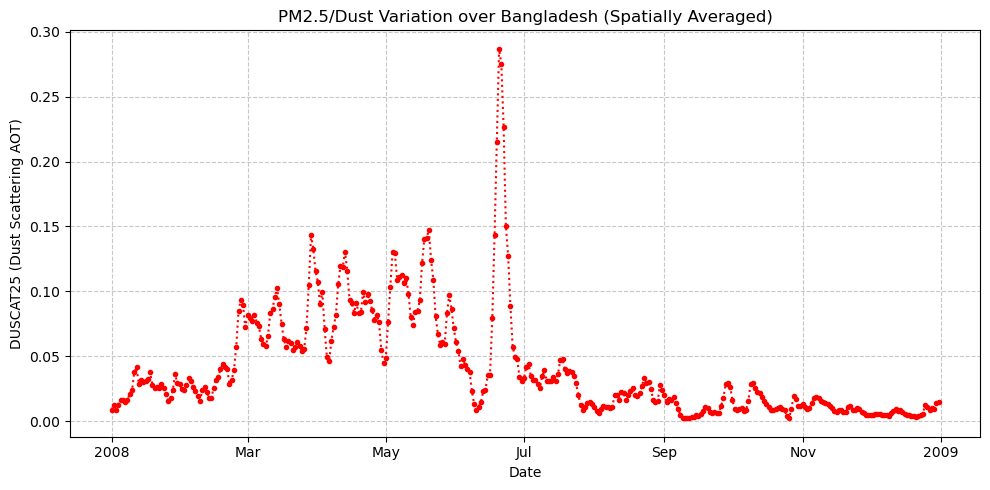

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
timeseries_data.plot(ax=ax, marker='o', linestyle=':', markersize=3, color='red')

ax.set_xlabel('Date')
ax.set_ylabel('DUSCAT25 (Dust Scattering AOT)')
ax.set_title('PM2.5/Dust Variation over Bangladesh (Spatially Averaged)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('BD_pm25.png', dpi=300)
plt.show()

In [86]:
# 1. Compute the mean (Average over time)
ds_mean = ds['DUSCAT25'].mean(dim='time').compute()

# 2. Check if we have enough data for a map (Grid vs. Single Point)
plt.figure(figsize=(10, 6))

if ds_mean.ndim >= 2 and ds_mean.size > 1:
    # --- CASE A: Large Area (Map) ---
    ds_mean.plot(cmap='coolwarm', robust=True)
    plt.title(f"Spatial Distribution of Dust (Mean)")
    
    # Save the map directly
    plt.savefig("map_spatial.png", dpi=300, bbox_inches='tight')
    print("✅ Success! Spatial map saved as 'map_spatial.png'")

else:
    # --- CASE B: Single Point/Small City (Time Series) ---
    print("⚠️ Area is too small for a spatial map (1 pixel). Saving Time Series graph instead.")
    
    # Get the time series for this point
    ts_data = ds['DUSCAT25'].mean(dim=['lat', 'lon']).compute()
    
    # Plot the line graph
    ts_data.plot(marker='o', linestyle='-', color='red', markersize=3)
    plt.title("Dust Variation (Single Location)")
    plt.xlabel("Date")
    plt.ylabel("DUSCAT25")
    plt.grid(True)
    
    # Save the graph directly
    plt.savefig("map_timeseries.png", dpi=300, bbox_inches='tight')
    print("✅ Success! Time series graph saved as 'map_timeseries.png'")

plt.close() # Closes the plot to free up memory

✅ Success! Spatial map saved as 'map_spatial.png'
